In [56]:
import numpy as np
import pandas as pd
import nltk
# nltk.download()
import nltk.classify.util
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.tokenize import RegexpTokenizer
# import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
!ls

gdrive	sample_data


In [57]:
data = pd.read_csv('/content/gdrive/My Drive/Womens Clothing E-Commerce Reviews.csv',index_col =[0])

In [58]:
data.head(2)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [59]:
data.shape

(23486, 10)

In [60]:
data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


In [61]:
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}')
stop_words = set(stopwords.words('english'))
def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') 
    words = tokenizer.tokenize(txt) 
    words = [w for w in words if not w in stop_words] 
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
data['tokenized'] = data["Review Text"].astype(str).str.lower() 
data['tokenized'] = data.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) 
data['tokenized'] = data['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) 

In [63]:
def string_unlist(strlist):
    return " ".join(strlist)
data["tokenized_unlist"] = data["tokenized"].apply(string_unlist)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,tokenized,tokenized_unlist
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"[absolutely, wonderful, silky, sexy, comfortable]",absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"[love, dress, sooo, pretty, happened, find, st...",love dress sooo pretty happened find store gla...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"[high, hopes, dress, really, wanted, work, ini...",high hopes dress really wanted work initially ...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"[love, love, love, jumpsuit, fun, flirty, fabu...",love love love jumpsuit fun flirty fabulous ev...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"[shirt, flattering, due, adjustable, front, ti...",shirt flattering due adjustable front tie perf...


In [64]:
# nltk.download('vader_lexicon')
SIA = SentimentIntensityAnalyzer()
data['Polarity Score']=data["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['compound'])
data['Neutral Score']=data["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['neu'])
data['Negative Score']=data["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['neg'])
data['Positive Score']=data["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['pos'])
data['Sentiment']=''
data.loc[data['Polarity Score']>0,'Sentiment']='Positive'
data.loc[data['Polarity Score']==0,'Sentiment']='Neutral'
data.loc[data['Polarity Score']<0,'Sentiment']='Negative'

In [65]:
conditions = [
    data['Sentiment'] == "Positive",
    data['Sentiment'] == "Negative",
    data['Sentiment'] == "Neutral"]
choices = [1,-1,0]
data['label'] = np.select(conditions, choices)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,tokenized,tokenized_unlist,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment,label
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"[absolutely, wonderful, silky, sexy, comfortable]",absolutely wonderful silky sexy comfortable,0.8991,0.154,0.000,0.846,Positive,1
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"[love, dress, sooo, pretty, happened, find, st...",love dress sooo pretty happened find store gla...,0.9710,0.468,0.000,0.532,Positive,1
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"[high, hopes, dress, really, wanted, work, ini...",high hopes dress really wanted work initially ...,0.8779,0.721,0.040,0.240,Positive,1
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"[love, love, love, jumpsuit, fun, flirty, fabu...",love love love jumpsuit fun flirty fabulous ev...,0.9464,0.185,0.171,0.644,Positive,1
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"[shirt, flattering, due, adjustable, front, ti...",shirt flattering due adjustable front tie perf...,0.9062,0.494,0.000,0.506,Positive,1


In [66]:
samples = data["tokenized_unlist"].tolist()
maxlen = 100 
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data1 = pad_sequences(sequences, maxlen=maxlen)

Found 13241 unique tokens.


In [67]:
labels = np.asarray(data["label"].values)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data1 = data1[indices]
labels = labels[indices]
training_samples = 11743
validation_samples = 17614
x_train = data1[:training_samples]
y_train = labels[:training_samples]
x_val = data1[training_samples: validation_samples] 
y_val = labels[training_samples: validation_samples]
x_test = data1[validation_samples:]
y_test = labels[validation_samples:]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [68]:
model = Sequential() 
model.add(Embedding(max_words, 100, input_length=maxlen)) 
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()
history_RNN = model.fit(x_train, y_train,
                    epochs=2,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,004,289
Trainable params: 1,004,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
367/367 [==============================] - 12s 32ms/step - loss: 0.2493 - acc: 0.9508 - val_loss: 0.1922 - val_acc: 0.9664
Epoch 2/2
367/367 [==============================] - 12s 32ms/step - loss: 0.1371 - acc: 0.9593 - val_loss: 0.2095 - val_acc: 0.9486


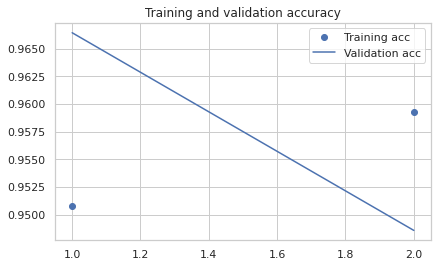

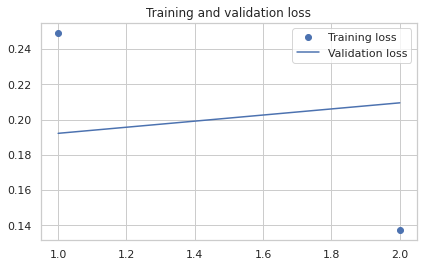

In [69]:
acc = history_RNN.history['acc']
val_acc = history_RNN.history['val_acc']
loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [70]:
model.evaluate(x_test, y_test)

184/184 [==============================] - 1s 7ms/step - loss: 0.2172 - acc: 0.9447


[0.21720623970031738, 0.9446526169776917]